# Práctica 2 

Aprendizaje Máquina 
 
**Implementa al menos tres de los ejemplos propuestos al final de la documentación.**

## Clustering text documents using k-means

Este es un ejemplo que muestra cómo se puede utilizar la API scikit-learn para agrupar documentos por temas utilizando un enfoque de Bolsa de palabras.

Se demuestran dos algoritmos, KMeans y su variante más escalable, MiniBatchKMeans. Además, el análisis semántico latente se utiliza para reducir la dimensionalidad y descubrir patrones latentes en los datos.

Este ejemplo utiliza dos vectorizadores de texto diferentes: un TfidfVectorizer y un HashingVectorizer. 

Para el análisis de documentos mediante un enfoque de aprendizaje supervisado, consulte el script de ejemplo Clasificación de documentos de texto utilizando funciones dispersas.


#### Autores del ejemplo propuesto. 

Peter Prettenhofer <peter.prettenhofer@gmail.com>
         Lars Buitinck
         Olivier Grisel <olivier.grisel@ensta.org>
         Arturo Amor <david-arturo.amor-quiroz@inria.fr>
License: BSD 3 clause

#### Recuperado de

https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

In [29]:
# Práctica 2 

# Clustering text documents using k-means

import numpy as np 

from sklearn.datasets import fetch_20newsgroups

#Lista de articulos de texto
categories= [
    "alt.atheism", 
    "talk.religion.misc", 
    "comp.graphics", 
    "sci.space", 
]

In [15]:
#limpiar la info del dataset 
dataset= fetch_20newsgroups(
    remove=("headers","footers","quotes"), 
    subset="all", 
    categories=categories, 
    shuffle=True,
    random_state=42, 
)


#se recupera el número de documentos y categorias del dataset 
labels= dataset.target 
unique_labels, category_sizes= np.unique(labels, return_counts= True)
true_k= unique_labels.shape[0]
print(f"{len(dataset.data)} documentos -{true_k} categorias")


3387 documentos -4 categorias


In [38]:
from collections import defaultdict
from time import time

from sklearn import metrics

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering hecho en:  {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"vectorizacion hecha en: {time() - t0:.3f} s")
print(f"muestras: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorizacion hecha en: 0.614 s
muestras: 3387, n_features: 7929


In [18]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.007


In [32]:
from sklearn.cluster import KMeans

for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Numero de elementos asignados a cada cluster: {cluster_sizes}")
print()
print(
    "Número verdadero de Documentos en cada categoria según las etiquetas (labels) de clases: "
    f"{category_sizes}"
)

Numero de elementos asignados a cada cluster: [ 481  675 1785  446]
Numero de elementos asignados a cada cluster: [1689  638  480  580]
Numero de elementos asignados a cada cluster: [   1    1    1 3384]
Numero de elementos asignados a cada cluster: [1887  311  332  857]
Numero de elementos asignados a cada cluster: [ 291  673 1771  652]

Número verdadero de Documentos en cada categoria según las etiquetas (labels) de clases: [799 973 987 628]


In [20]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

clustering hecho en:  0.24 ± 0.04 s 
Homogeneity: 0.349 ± 0.010
Completeness: 0.398 ± 0.009
V-measure: 0.372 ± 0.009
Adjusted Rand-Index: 0.203 ± 0.017
Silhouette Coefficient: 0.007 ± 0.001


In [33]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA hecho en: {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA hecho en: 0.784 s
Explained variance of the SVD step: 18.4%


In [34]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering hecho en:  0.09 ± 0.04 s 
Homogeneity: 0.399 ± 0.003
Completeness: 0.447 ± 0.011
V-measure: 0.421 ± 0.007
Adjusted Rand-Index: 0.326 ± 0.011
Silhouette Coefficient: 0.030 ± 0.001


In [35]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=true_k,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)

fit_and_evaluate(
    minibatch_kmeans,
    X_lsa,
    name="MiniBatchKMeans\nwith LSA on tf-idf vectors",
)

clustering hecho en:  0.11 ± 0.03 s 
Homogeneity: 0.304 ± 0.066
Completeness: 0.333 ± 0.067
V-measure: 0.317 ± 0.066
Adjusted Rand-Index: 0.276 ± 0.047
Silhouette Coefficient: 0.027 ± 0.004


In [24]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: space nasa shuttle station sci launch program like think just 
Cluster 1: thanks graphics image know files edu file does program looking 
Cluster 2: god people think don say just jesus religion know believe 
Cluster 3: just like orbit earth time moon years launch think mission 


In [36]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(dataset.data)
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 3.657 s


In [26]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

clustering hecho en:  0.08 ± 0.04 s 
Homogeneity: 0.395 ± 0.010
Completeness: 0.446 ± 0.015
V-measure: 0.419 ± 0.012
Adjusted Rand-Index: 0.320 ± 0.013
Silhouette Coefficient: 0.030 ± 0.001


In [37]:
fit_and_evaluate(
    minibatch_kmeans,
    X_hashed_lsa,
    name="MiniBatchKMeans\nwith LSA on hashed vectors",
)

clustering hecho en:  0.08 ± 0.04 s 
Homogeneity: 0.343 ± 0.053
Completeness: 0.354 ± 0.047
V-measure: 0.348 ± 0.050
Adjusted Rand-Index: 0.303 ± 0.055
Silhouette Coefficient: 0.025 ± 0.003


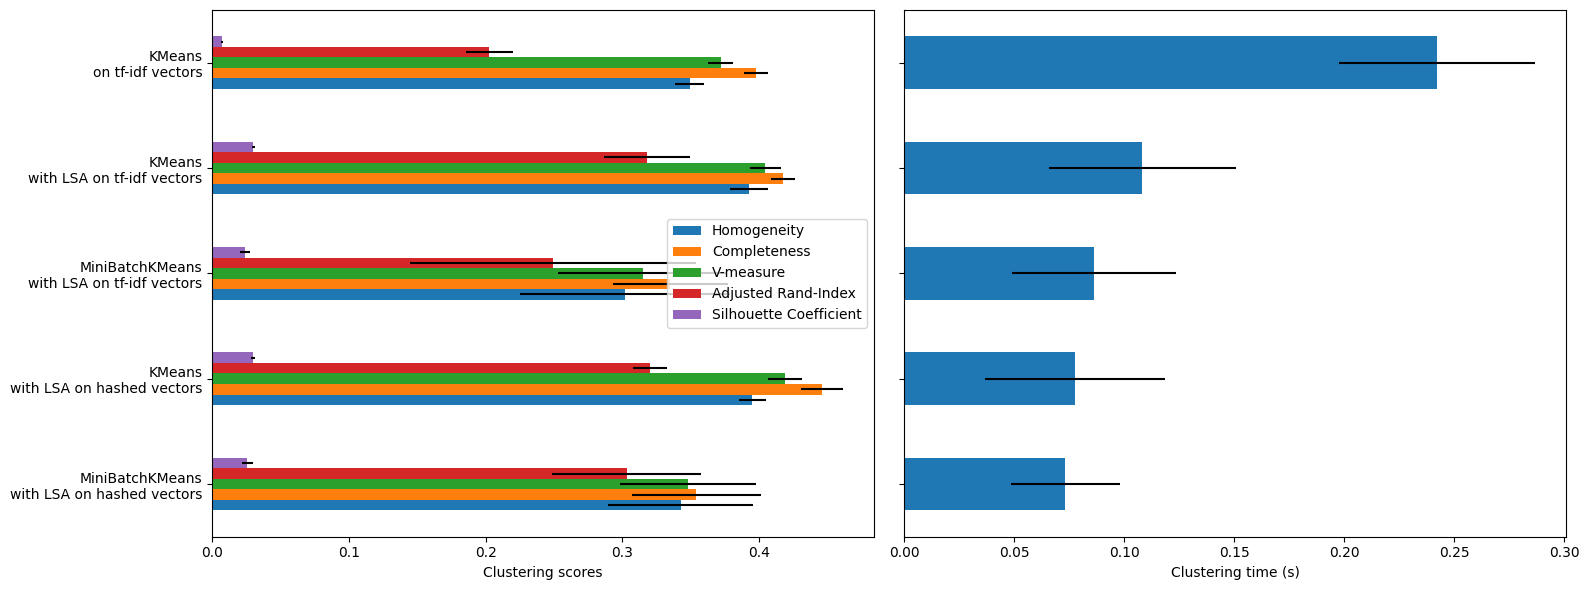

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()